In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Machine Learning for Biomedicine: Final Project

Pau Altur Pastor NIA: 216904

Francesc Carandell Verdaguer NIA: 217206

## Football analytics

Football or soccer as it is called in America is the most popular sport in the world. The World Cup final is the most watched sport event worldwide and superstar footballers like Lionel Messi or Cristiano Ronaldo are the most followed personalities on social media. Consequently, during the last three decades football has evolved from a mere sporting discipline into a billion euro industry where player transfers can command fees into the hundred million euros and beyond. As such interest has increased around sports analytics methods that can better predict the future performance of a player when considering whether or not to pursue a player. A miss in the transfer market can mean hundreds of millions of dollars wasted in fees and player wages as 
evidenced by FC Barcelona's transfer strategy since the summer of 2017.

![neymar.jpg](https://drive.google.com/uc?id=1qca1CinnYYBpv2ifqoCKH5DQ5yni7cD7)

## Data curation and preprocessing

Before performing any kind of data analytics we must first prepare our dataset adequately. In our case the data has been extracted from the website FBref (https://fbref.com/en/). The statistics we are considering are from the 5 major European leagues (Premier League, La Liga, Serie A, Bundesliga and Ligue 1) and consist of shooting, passing, pass types and goal and shot creating actions data. We have excluded data from dead-ball situations due to two reasons. First, they are related to a specialized skillset which tells us very little about the rest of the game of a high-level player when comparing him to his peers. Second, it is sparse data as on any given time few forwards take dead ball situations (free kicks, corner kicks...) and so the differences between players have more to do with the specific responsibilities of each player within the team than with their quality or style.

Most of this data is adjusted per 90 minutes played. This removes the bias towards players who have had more game time and thus more chances to perform the actions recorded.

This data has been downloaded in CSV format (spreadsheet-like files with the data split into rows where columns are separated by commas). To handle and edit it we will use the pandas data processing library which contains functions that allow us to import data in CSV format and work with it in an efficient way. In our case we will start by importing the data with the read_csv() function which converts the imported file into a panda's DataFrame. We will continue by removing unwanted columns with the drop method of the DataFrame object.

In [2]:
! pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

In [4]:
folder = "5_90"
files = ["shooting.csv", "passing.csv", "passtypes.csv", "gsca.csv"]
data_dict = {}

for file in files:
  path = "/content/drive/Shareddrives/Kane & Son/ML/Data/"+folder+"/"+file
  aux = pd.read_csv(path)
  aux.drop(["Rk","Matches"], axis = 'columns', inplace = True)
  if file != files[0]:
    aux.drop(["Player", "Nation" ,"Comp", "Squad", "Pos", "90s", "Age", "Born"], axis = 'columns', inplace = True)
  if file == "passtypes.csv":
    aux.drop(["In", "Out", "Str", "Dead", "FK", "CK",'Att',"Cmp"], axis = "columns", inplace = True)
  if file == "gsca.csv":
    aux.drop(["PassDead","GCA","SCA"], axis = "columns", inplace = True)
    aux.rename(columns = {"Sh": "sSh", "Sh.1": "gSh"}, inplace= True)
  if file == "shooting.csv":
    aux.drop(["FK", "PK", "PKatt"], axis = 'columns', inplace = True)
  data_dict[file[:-4]] = aux

Now we must concatenate all the data into a single DataFrame for ease of handle. Then we will save it and open it again in the next step.

In [5]:
Data = pd.concat([data_dict["shooting"], data_dict["passing"], data_dict["passtypes"], data_dict["gsca"]], axis = 1)
Data.head()

,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,xG,npxG,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,Cmp.2,Att.2,Cmp%.2,Cmp.3,Att.3,Cmp%.3,Ast,xA,A-xA,KP,1/3,PPA,CrsPA,Prog,Live,TB,Press,Sw,Crs,Ground,Low,High,Left,Right,Head,TI,Other,Off,Out.1,Int,Blocks,SCA90,PassLive,Drib,sSh,Fld,Def,GCA90,PassLive.1,PassDead.1,Drib.1,gSh,Fld.1,Def.1
0,Ismael Aaneba\Ismael-Aaneba,fr FRA,FWDF,Strasbourg,fr Ligue 1,21.0,1999.0,0.1,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,20.0,20.0,100.0,570.0,150.0,0.00,0.00,NaN,10.00,10.00,100.0,10.00,10.00,100.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,20.0,0.0,0.00,10.00,0.00,20.0,0.00,0.00,0.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
1,Patrick van Aanholt\Patrick-van-Aanholt,nl NED,DF,Crystal Palace,eng Premier League,29.0,1990.0,19.7,0.00,0.91,0.30,33.3,0.91,0.30,0.0,0.0,20.3,0.06,0.06,0.07,-0.06,-0.06,45.1,57.2,78.9,756.6,352.5,23.00,26.00,88.7,17.30,21.20,81.3,3.96,7.66,51.7,0.05,0.04,0.01,0.56,3.45,1.32,0.2,5.69,47.3,0.1,5.69,1.02,1.73,36.4,11.10,9.70,37.70,9.85,1.27,7.97,0.15,0.61,1.12,1.47,1.73,1.32,1.12,0.05,0.00,0.0,0.0,0.15,0.1,0.05,0.0,0.0,0.0,0.0
2,Issah Abbas\Issah-Abbas,gh GHA,DFFW,Mainz 05,de Bundesliga,21.0,1998.0,0.2,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,65.0,75.0,86.7,1300.0,530.0,30.00,35.00,85.7,25.00,30.00,83.3,10.00,10.00,100.0,0.00,0.00,0.00,0.00,5.00,0.00,0.0,5.00,60.0,0.0,0.00,0.00,0.00,50.0,20.00,5.00,0.00,60.00,0.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
3,Yunis Abdelhamid\Yunis-Abdelhamid,ma MAR,DF,Reims,fr Ligue 1,32.0,1987.0,32.1,0.09,0.47,0.16,33.3,0.47,0.16,0.2,0.6,10.2,0.05,0.05,0.11,0.04,0.04,46.9,53.4,87.8,1049.7,361.9,10.50,11.70,89.1,27.80,29.60,93.9,8.32,11.40,73.0,0.00,0.01,-0.01,0.12,2.52,0.03,0.0,2.83,51.6,0.0,5.23,1.21,0.00,42.5,3.86,7.04,35.40,14.80,1.78,0.00,0.09,0.12,0.81,0.75,0.40,0.34,0.31,0.00,0.03,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0
4,Sabit Abdulai\Sabit-Abdulai,gh GHA,MF,Getafe,es La Liga,21.0,1999.0,0.7,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,10.0,17.1,58.3,190.0,12.9,2.86,2.86,100.0,5.71,7.14,80.0,1.43,4.29,33.3,0.00,0.00,0.00,0.00,0.00,1.43,0.0,1.43,17.1,0.0,10.00,1.43,1.43,11.4,0.00,5.71,1.43,14.30,1.43,0.00,0.00,0.00,1.43,1.43,1.43,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0


The next step is to select only the data of players classified as forwards. This can prove tricky as most forwards can be difficult to categorize given that they can oftentimes play either in the front line or as attacking midfielders. To solve this problem we will create a function which recognizes when a player has the letters FW in his Pos attribute and sets it to simply FW.

In [6]:
def fw_finder(name):
  for i in range(len(name)-1):
    if name[i] == "F":
      if name[i+1] == "W":
        return "FW"
        break
  return name

for i in range(len(Data)):
  Data.loc[i, "Pos"] = fw_finder(Data.Pos[i])

Data_FW = Data.loc[Data["Pos"] == "FW", :].copy()
Data_FW.head()

,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,xG,npxG,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,Cmp.2,Att.2,Cmp%.2,Cmp.3,Att.3,Cmp%.3,Ast,xA,A-xA,KP,1/3,PPA,CrsPA,Prog,Live,TB,Press,Sw,Crs,Ground,Low,High,Left,Right,Head,TI,Other,Off,Out.1,Int,Blocks,SCA90,PassLive,Drib,sSh,Fld,Def,GCA90,PassLive.1,PassDead.1,Drib.1,gSh,Fld.1,Def.1
0,Ismael Aaneba\Ismael-Aaneba,fr FRA,FW,Strasbourg,fr Ligue 1,21.0,1999.0,0.1,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,20.0,20.0,100.0,570.0,150.0,0.00,0.0,NaN,10.00,10.00,100.0,10.00,10.00,100.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,20.0,0.0,0.00,10.00,0.00,20.0,0.00,0.00,0.00,20.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0
2,Issah Abbas\Issah-Abbas,gh GHA,FW,Mainz 05,de Bundesliga,21.0,1998.0,0.2,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,65.0,75.0,86.7,1300.0,530.0,30.00,35.0,85.7,25.00,30.00,83.3,10.00,10.00,100.0,0.00,0.00,0.00,0.00,5.00,0.00,0.0,5.00,60.0,0.0,0.00,0.00,0.00,50.0,20.00,5.00,0.00,60.00,0.00,15.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0
7,Charles Abi\Charles-Abi,fr FRA,FW,Saint-Étienne,fr Ligue 1,20.0,2000.0,10.1,0.30,1.88,0.40,21.1,1.87,0.39,0.16,0.75,11.8,0.21,0.21,0.11,0.09,0.09,14.3,21.2,67.3,188.0,33.1,8.32,10.8,77.1,3.66,5.15,71.2,0.59,1.98,30.0,0.20,0.03,0.17,0.79,0.89,0.50,0.0,1.09,19.7,0.1,7.62,0.20,0.40,13.9,3.27,4.06,14.10,2.57,1.58,0.0,0.30,0.0,0.69,0.10,1.39,1.38,1.09,0.10,0.00,0.10,0.0,0.20,0.20,0.0,0.0,0.0,0.00,0.0
8,Matthis Abline\Matthis-Abline,fr FRA,FW,Rennes,fr Ligue 1,17.0,2003.0,0.0,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,NaN,0.00,0.00,NaN,0.00,0.00,0.0,1.0,0.0,0.0,0.0,0.00,1.0,0.0,0.00,0.00,NaN,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1.0,0.0,0.00,0.00,0.00,1.0,0.00,0.00,0.00,1.00,0.00,0.0,0.00,0.0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.0
11,Tammy Abraham\Tammy-Abraham,eng ENG,FW,Chelsea,eng Premier League,22.0,1997.0,11.6,0.52,2.76,1.12,40.6,2.77,1.13,0.19,0.46,9.7,0.55,0.55,0.20,-0.03,-0.03,12.8,18.8,68.3,177.3,28.2,7.93,10.2,78.0,3.36,5.52,60.9,0.78,1.29,60.0,0.09,0.08,0.01,0.69,1.03,0.17,0.0,0.95,17.9,0.0,6.64,0.09,0.34,11.7,4.66,2.41,1.47,12.70,1.55,0.0,1.03,0.0,0.34,0.26,1.12,1.56,0.95,0.09,0.26,0.26,0.0,0.17,0.09,0.0,0.0,0.0,0.09,0.0


This dataset however, contains all of the players that have played even a single minute of league football this season. For our analysis we are only interested in those footballers who have played somewhat consistently so that our findings are not biased by the small sample size of minutes of some players. The threshold we have defined is 900 minutes. We will only consider players who have played at least 10 whole matches worth of minutes this season in the great 5 European leagues.

In [7]:
Data_FW_900 = Data_FW.loc[Data_FW["90s"] >= 900/90, :].copy()
Data_FW_900.head()

,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,xG,npxG,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,Cmp.2,Att.2,Cmp%.2,Cmp.3,Att.3,Cmp%.3,Ast,xA,A-xA,KP,1/3,PPA,CrsPA,Prog,Live,TB,Press,Sw,Crs,Ground,Low,High,Left,Right,Head,TI,Other,Off,Out.1,Int,Blocks,SCA90,PassLive,Drib,sSh,Fld,Def,GCA90,PassLive.1,PassDead.1,Drib.1,gSh,Fld.1,Def.1
7,Charles Abi\Charles-Abi,fr FRA,FW,Saint-Étienne,fr Ligue 1,20.0,2000.0,10.1,0.30,1.88,0.40,21.1,1.87,0.39,0.16,0.75,11.8,0.21,0.21,0.11,0.09,0.09,14.3,21.2,67.3,188.0,33.1,8.32,10.80,77.1,3.66,5.15,71.2,0.59,1.98,30.0,0.20,0.03,0.17,0.79,0.89,0.50,0.00,1.09,19.7,0.10,7.62,0.20,0.40,13.9,3.27,4.06,14.10,2.57,1.58,0.00,0.30,0.00,0.69,0.10,1.39,1.38,1.09,0.10,0.00,0.10,0.0,0.20,0.20,0.0,0.00,0.00,0.00,0.0
11,Tammy Abraham\Tammy-Abraham,eng ENG,FW,Chelsea,eng Premier League,22.0,1997.0,11.6,0.52,2.76,1.12,40.6,2.77,1.13,0.19,0.46,9.7,0.55,0.55,0.20,-0.03,-0.03,12.8,18.8,68.3,177.3,28.2,7.93,10.20,78.0,3.36,5.52,60.9,0.78,1.29,60.0,0.09,0.08,0.01,0.69,1.03,0.17,0.00,0.95,17.9,0.00,6.64,0.09,0.34,11.7,4.66,2.41,1.47,12.70,1.55,0.00,1.03,0.00,0.34,0.26,1.12,1.56,0.95,0.09,0.26,0.26,0.0,0.17,0.09,0.0,0.00,0.00,0.09,0.0
17,Che Adams\Che-Adams,sco SCO,FW,Southampton,eng Premier League,24.0,1996.0,29.6,0.30,1.89,1.05,55.4,1.89,1.05,0.16,0.29,13.1,0.30,0.30,0.16,0.01,0.01,15.0,21.4,70.0,248.6,55.2,7.67,10.20,75.2,4.83,6.22,77.7,1.72,2.47,69.9,0.17,0.20,-0.03,1.15,0.91,0.84,0.07,2.06,21.0,0.27,5.95,0.47,0.44,13.4,4.22,3.72,1.32,16.90,1.22,0.00,0.81,0.20,0.30,0.95,1.11,2.23,1.62,0.03,0.20,0.27,0.1,0.27,0.24,0.0,0.00,0.00,0.03,0.0
28,Kevin Agudelo\Kevin-Agudelo,co COL,FW,Spezia,it Serie A,21.0,1998.0,15.1,0.07,1.26,0.26,21.1,1.26,0.27,0.05,0.25,17.3,0.13,0.13,0.10,-0.06,-0.06,15.4,21.2,72.5,277.6,60.9,7.22,8.81,82.0,5.83,7.68,75.9,1.92,3.18,60.4,0.13,0.05,0.09,0.73,1.19,0.79,0.00,1.99,20.1,0.00,6.62,0.60,0.66,14.7,3.97,2.52,16.70,2.65,0.66,0.13,0.13,0.07,0.73,0.46,1.26,2.32,1.13,0.26,0.33,0.33,0.2,0.27,0.20,0.0,0.00,0.07,0.00,0.0
31,Ruben Aguilar\Ruben-Aguilar,fr FRA,FW,Monaco,fr Ligue 1,27.0,1993.0,24.7,0.04,0.32,0.12,37.5,0.32,0.12,0.13,0.33,9.6,0.05,0.05,0.15,-0.01,-0.01,53.3,64.7,82.4,908.8,277.0,25.40,27.60,91.9,21.50,25.70,83.6,4.90,8.66,56.5,0.12,0.19,-0.06,1.78,3.12,1.50,0.69,3.81,55.6,0.08,5.38,2.06,4.05,41.4,9.96,13.40,1.34,52.80,2.19,6.92,0.20,0.20,0.65,0.97,1.26,2.91,2.27,0.08,0.04,0.16,0.0,0.32,0.24,0.0,0.04,0.00,0.04,0.0


Now we will check whether there are any NaN values in the dataset and drop them.

In [8]:
Data_FW_900.isna().sum()

Player        0
Nation        0
Pos           0
Squad         0
Comp          0
             ..
PassDead.1    0
Drib.1        0
gSh           0
Fld.1         0
Def.1         0
Length: 74, dtype: int64

Next, we will normalize the features by substracting the minimum and dividing by the maximum. Thus, all of the values will be scaled between 0 and 1 and this will help the algorithm in its task.

To do this normalization we will split the data into two DataFrames: forwards (data which gives information unrelated to performance such as name, team and competition) and stats (data that has a relationship with on-field performance).

In [9]:
forwards = Data_FW_900.iloc[:, 0:7].copy()
stats = Data_FW_900.iloc[:, 7:].copy()

stats = (stats - stats.min())/stats.max()

In [10]:
forwards.head()

,Player,Nation,Pos,Squad,Comp,Age,Born
7,Charles Abi\Charles-Abi,fr FRA,FW,Saint-Étienne,fr Ligue 1,20.0,2000.0
11,Tammy Abraham\Tammy-Abraham,eng ENG,FW,Chelsea,eng Premier League,22.0,1997.0
17,Che Adams\Che-Adams,sco SCO,FW,Southampton,eng Premier League,24.0,1996.0
28,Kevin Agudelo\Kevin-Agudelo,co COL,FW,Spezia,it Serie A,21.0,1998.0
31,Ruben Aguilar\Ruben-Aguilar,fr FRA,FW,Monaco,fr Ligue 1,27.0,1993.0


In [11]:
stats.head()

,90s,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,xG,npxG,npxG/Sh,G-xG,np:G-xG,Cmp,Att,Cmp%,TotDist,PrgDist,Cmp.1,Att.1,Cmp%.1,Cmp.2,Att.2,Cmp%.2,Cmp.3,Att.3,Cmp%.3,Ast,xA,A-xA,KP,1/3,PPA,CrsPA,Prog,Live,TB,Press,Sw,Crs,Ground,Low,High,Left,Right,Head,TI,Other,Off,Out.1,Int,Blocks,SCA90,PassLive,Drib,sSh,Fld,Def,GCA90,PassLive.1,PassDead.1,Drib.1,gSh,Fld.1,Def.1
7,0.002703,0.200000,0.276106,0.134387,0.185596,0.273852,0.130435,0.484848,0.75,0.099631,0.155172,0.200000,0.307692,0.928571,0.928571,0.088517,0.102210,0.124861,0.038423,0.050696,0.110355,0.119947,0.141949,0.068610,0.066926,0.190782,0.022131,0.089820,0.030675,0.263158,0.058824,1.028571,0.216438,0.093385,0.108932,0.00000,0.074231,0.108664,0.103093,0.386131,0.035842,0.079208,0.126549,0.134483,0.166484,0.213050,0.019846,0.347630,0.000000,0.114943,0.000000,0.368421,0.003344,0.285714,0.066505,0.113725,0.084746,0.000000,0.112360,0.000000,0.169492,0.196078,0.0,0.000000,0.000000,0.000000,0.0
11,0.043243,0.346667,0.431858,0.418972,0.455679,0.432862,0.422925,0.575758,0.46,0.022140,0.448276,0.577778,0.653846,0.714286,0.714286,0.064593,0.069061,0.136009,0.029544,0.035549,0.098817,0.103989,0.151483,0.055157,0.081323,0.080386,0.037705,0.048503,0.337423,0.118421,0.156863,0.571429,0.189041,0.111543,0.037037,0.00000,0.059385,0.082232,0.000000,0.314599,0.016129,0.067327,0.087611,0.254310,0.075824,0.014465,0.175692,0.340858,0.000000,0.394636,0.000000,0.163743,0.056856,0.212938,0.088271,0.086275,0.076271,0.309524,0.292135,0.000000,0.144068,0.088235,0.0,0.000000,0.000000,0.375000,0.0
17,0.529730,0.200000,0.277876,0.391304,0.660665,0.277385,0.391304,0.484848,0.29,0.147601,0.232759,0.300000,0.500000,0.785714,0.785714,0.099681,0.104972,0.154961,0.088714,0.119011,0.091124,0.103989,0.121822,0.121076,0.108560,0.260450,0.114754,0.119162,0.438650,0.223684,0.392157,0.457143,0.315068,0.095979,0.183007,0.06087,0.177094,0.127753,0.278351,0.264234,0.084229,0.087129,0.117699,0.216379,0.147802,0.012107,0.240308,0.266366,0.000000,0.310345,0.224719,0.140351,0.287625,0.210243,0.169287,0.217647,0.025424,0.238095,0.303371,0.294118,0.228814,0.235294,0.0,0.000000,0.000000,0.125000,0.0
28,0.137838,0.046667,0.166372,0.079051,0.185596,0.166078,0.083004,0.151515,0.25,0.302583,0.086207,0.111111,0.269231,0.660714,0.660714,0.106061,0.102210,0.182832,0.112780,0.136631,0.077811,0.067021,0.193856,0.165919,0.165370,0.241158,0.131148,0.161677,0.341513,0.171053,0.098039,0.800000,0.200000,0.132296,0.172113,0.00000,0.169671,0.114537,0.000000,0.313139,0.107527,0.130693,0.140708,0.194828,0.081868,0.253931,0.021077,0.139955,0.015116,0.049808,0.078652,0.391813,0.123746,0.250674,0.180169,0.121569,0.220339,0.392857,0.370787,0.588235,0.228814,0.196078,0.0,0.000000,0.233333,0.000000,0.0
31,0.397297,0.026667,0.000000,0.023715,0.412742,0.000000,0.023715,0.393939,0.33,0.018450,0.017241,0.022222,0.461538,0.750000,0.750000,0.710526,0.703039,0.293200,0.636598,0.804637,0.615680,0.566755,0.298729,0.868610,0.866537,0.323687,0.375410,0.489820,0.301636,0.157895,0.372549,0.371429,0.487671,0.382620,0.326797,0.60000,0.362672,0.635830,0.082474,0.222628,0.369176,0.801980,0.613274,0.711207,0.679670,0.012421,0.792615,0.485327,0.804651,0.076628,0.224719,0.345029,0.294314,0.250674,0.251511,0.345098,0.067797,0.047619,0.179775,0.000000,0.271186,0.235294,0.0,0.148148,0.000000,0.166667,0.0


In [12]:
stats.to_csv("/content/drive/Shareddrives/Kane & Son/ML/Data/stats.csv")

## Forward types analysis
Forward is a general category that groups most types of attacking players. They are the scorers and assisters and the players that lend "The Beautiful Game" its beauty. They can be classified into several subgroups according to more specific characteristics. However, these classifications have long and shifting meaning histories and oftentimes are loosely defined or overlapping. Let's look at Wikipedia (https://en.wikipedia.org/wiki/Forward_(association_football)) for an overview by no means exhaustive of Forward types:

>Centre-forward: The traditional role of a centre-forward is to score the majority of goals on behalf of the team. If they are tall and physical players, with good heading ability, the player may also be used to get onto the end of crosses, win long balls, or receive passes and retain possession of the ball with their back to goal as teammates advance.

> Striker: The role of a striker is rather different from that of a traditional centre-forward, although the terms centre-forward and striker are used interchangeably at times, as both play further up the field than other players. The traditional role of a striker is to score goals.

> Second striker: Deep-lying forwards have a long history in the game, but the terminology to describe their playing activity has varied over the years. More recently, two variations of this old type of player have developed: the second, or shadow, or support, or auxiliary striker and, in what is in fact a distinct position unto its own, the number 10. The second striker position is a loosely defined and most often misunderstood description of a player positioned in a free role, somewhere between the out-and-out striker, whether he or she is a "target man" or more of a "poacher", and the number 10 or attacking midfielder, while possibly showing some of the characteristics of both.

> A winger is an attacking player who is stationed in a wide position near the touchlines. It is a winger's duty to beat opposing full-backs, deliver cut-backs or crosses from wide positions and, to a lesser extent, to beat defenders and score from close range. They are usually some of the quickest players in the team and usually have good dribbling skills as well.
In recent years there has been a trend of playing inverted wingers – wide players stationed on the 'wrong' side of the pitch, in order to enable them to cut inside and shoot on their stronger foot and sometimes provide in-swinging crosses. 

> The false 9, in some ways similar to a more advanced attacking midfielder/playmaker role, is an unconventional lone striker or centre-forward, who drops deep into midfield. 

> The term "target forward" or "target man" is often used to describe a particular type of striker or centre-forward whose main role is to win high balls in the air, hold up the ball, and create chances for other members of the team in addition to scoring goals themselves.

As we can see these definitions are quite loose and oftentimes share common attributes. As such in the last few years there have been attempts to find better classification strategies. Herein, we want to apply an unsupervised machine learning approach to forwards' attributes. We will put their statistics through a series of clustering algorithm's and try to group players into subsets with common characteristics. This can both help us in understanding players and how they fit into the game and also to identify the closest stylistic matches for a specific player. The later of course could be hugely helpful in the transfer market when looking to identify a replacement for an aging player or an upgrade for an underperforming one.












### K-Means Clustering

K-Means clustering is an unsupervised machine learning algorithm which classifies n samples into k clusters by using an iterative algorithm which assigns examples to the nearest centroid (in terms of squared Euclidian distance) and then recomputes said centroid according to the members of the cluster. 

In [13]:
from sklearn.cluster import KMeans

In [14]:
K = np.arange(2,21)
inertias = []

for k in K:
  FW_KMeans = KMeans(n_clusters = k).fit(stats)
  inertias.append(FW_KMeans.inertia_)


When using the K-means algorithm a common question is raised: how do we choose the number K of clusters? In our case we will use the "elbow" method. It consists of computing the inertia of the clustering, which is the sum of squared distances of samples to their closest cluster center, and plotting it against the number of clusters. If the clustering has an optimal value K* or optimal range of such values we expect to see an elbow-like bend in the graph where the inertia stops decreasing as fast with an increasing number of clusters. This point yields a trade-off between minimizing inertia and having useful clusters. A clustering with K equal to the number of samples in the dataset will minimize inertia to 0 but it isn't of any use.

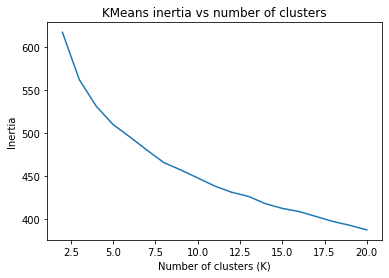

In [15]:
plt.plot(K, inertias)
plt.title("KMeans inertia vs number of clusters")
plt.ylabel("Inertia")
plt.xlabel("Number of clusters (K)")
plt.show()

We can see that the elbow region is located around 0 and 25. This also coincides with the approximate range of clusters that would provide an explainable number of groups. A large number of clusters would yield a classification that is too granular and not as explainable as needed. In our case we will choose a number of K = 10 clusters.

In [16]:
K_opt = 7
FW_KMeans = KMeans(n_clusters = K_opt).fit(stats)

Let's now create datasets with the players belonging to each cluster. This will help us in analyzing the rationale behind the clustering and extract useful information from the stats.

In [17]:
stats.loc[:, len(stats)] = FW_KMeans.labels_
Data_visual = pd.concat([forwards, stats], axis = "columns")
Data_visual.rename(columns = {489: "Cluster", "PassLive": "PL", "PassDead" : "PD", "PassLive.1": "PL.1", "PassDead.1" : "PD.1"}, inplace = True)

In [18]:
clusters = {}
for i in range(K_opt):
  aux = Data_visual.loc[Data_visual["Cluster"] == i, :].copy()
  aux.to_csv("/content/drive/Shareddrives/Kane & Son/ML/Data/Clusters/originals/cluster"+str(i))
  clusters["cluster"+str(i)] = aux

## Clusters analysis and visualization
Given the large number of features our clusters have been defined in a high dimensional space (83-dimensional). This presents an obvious problem for visualization because we as humans are not capable of visualising anything above 4-Dimensional (3 spatial dimensions plus an amplitude one for example a 3D scatter plot with information also encoded in the color of the dot).


### Mean and standard deviation of each cluster


To get a better grasp of how different features correlate with the clustering let's compute and display both the mean and standard deviation:

> The mean of the features will give us an intuiton of which are the positive (abilities) and negative (flaws) traits that define each cluster for example shot volume, progressive passing, progressive carries...

> The standard deviation of the features might give us an intuition of which features are most similar among members of a cluster. We will use this as a proxy of which are the most important features that define the cluster and which are less relevant.






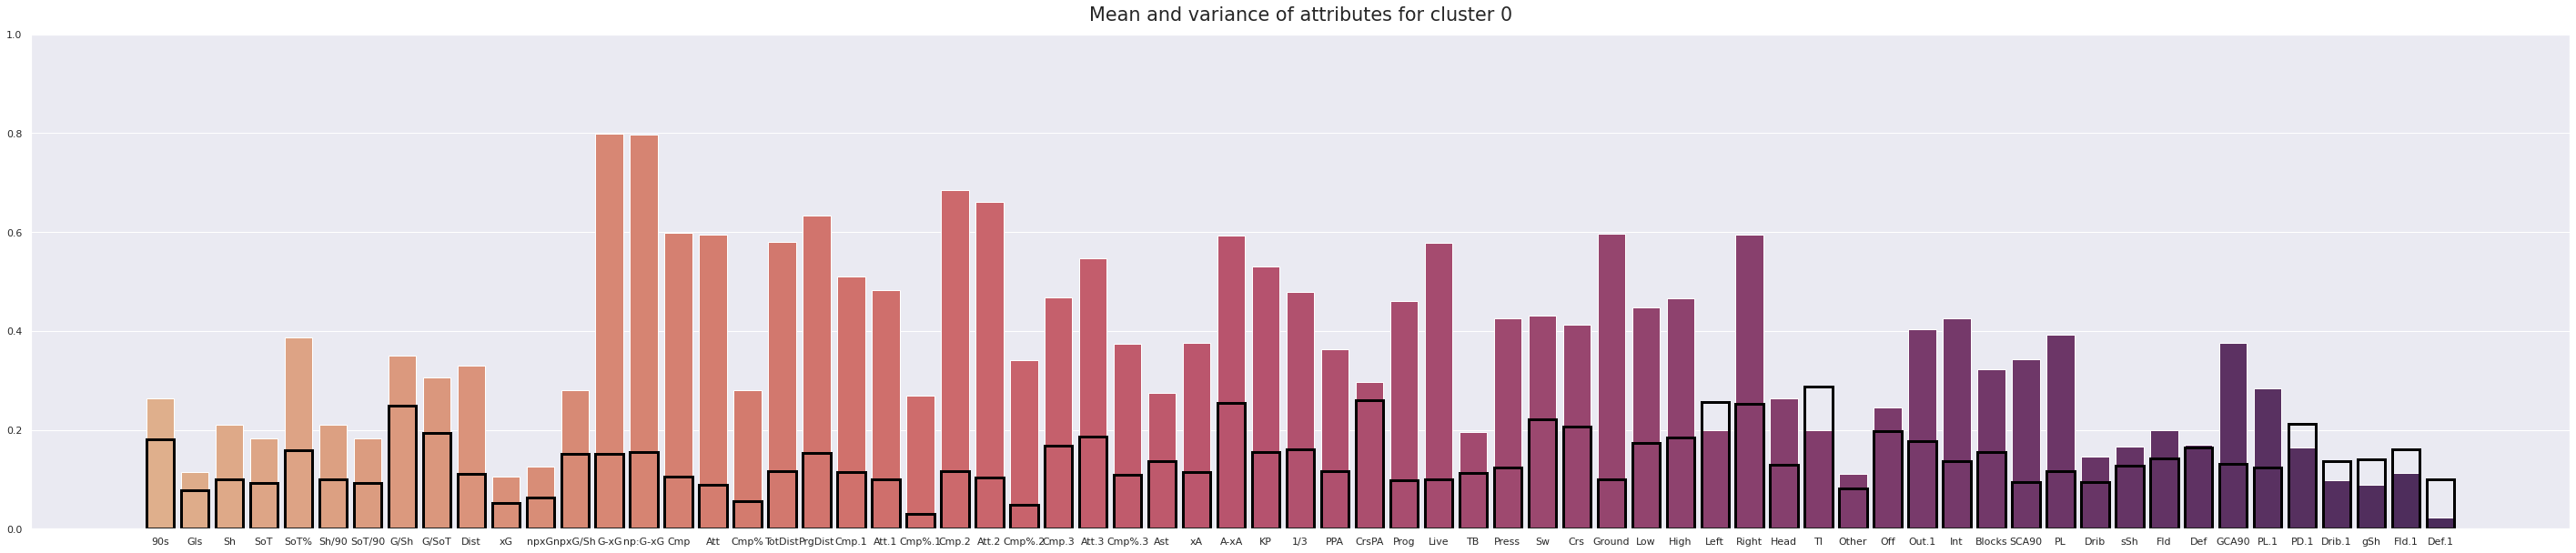

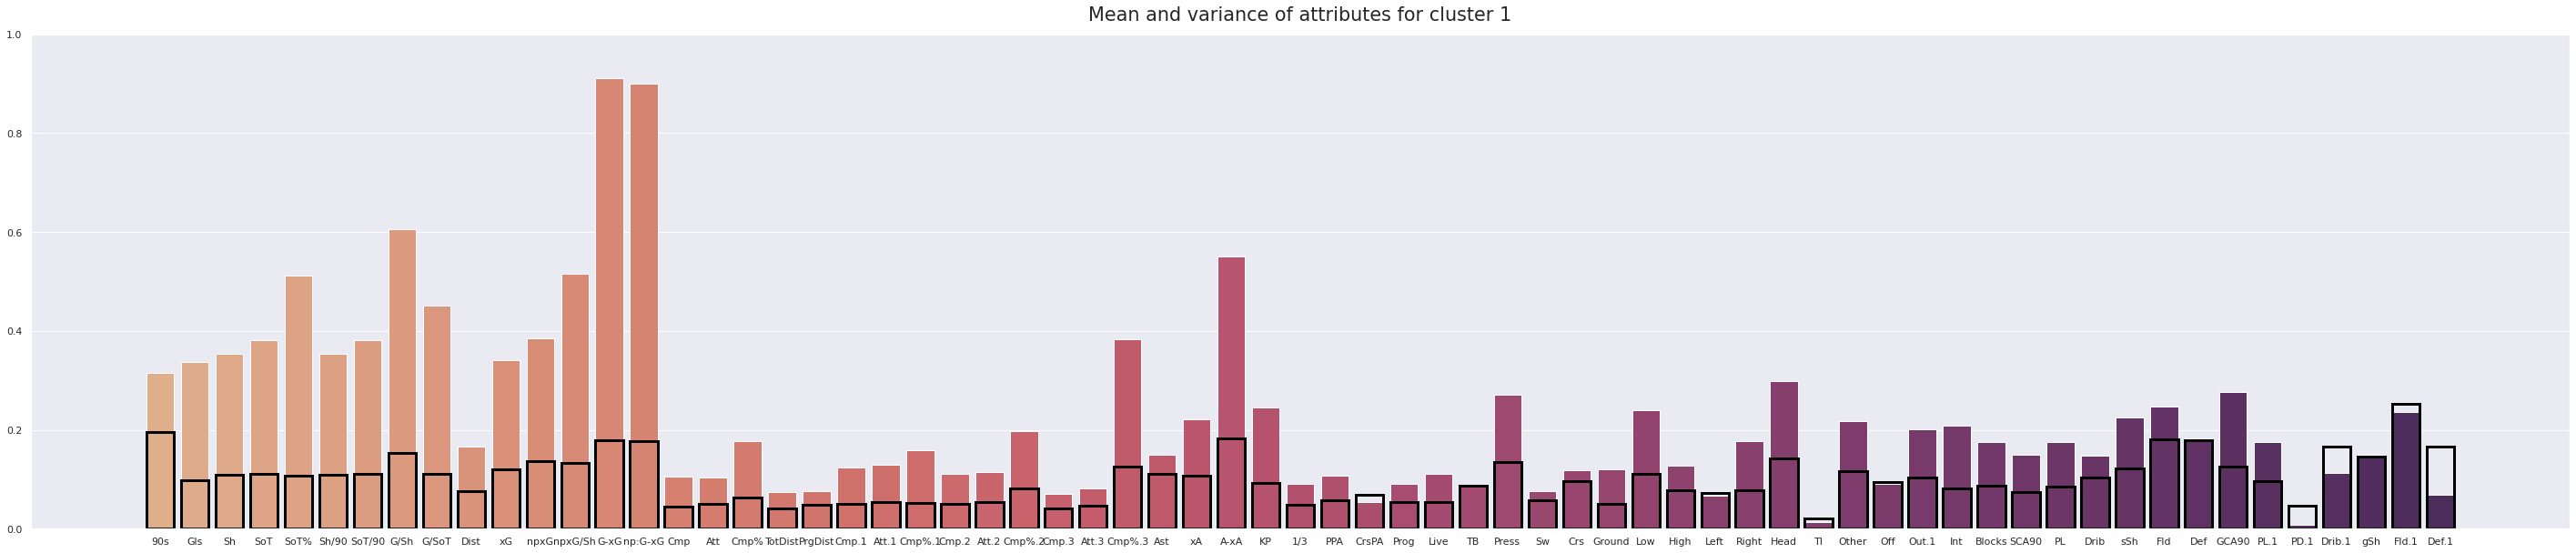

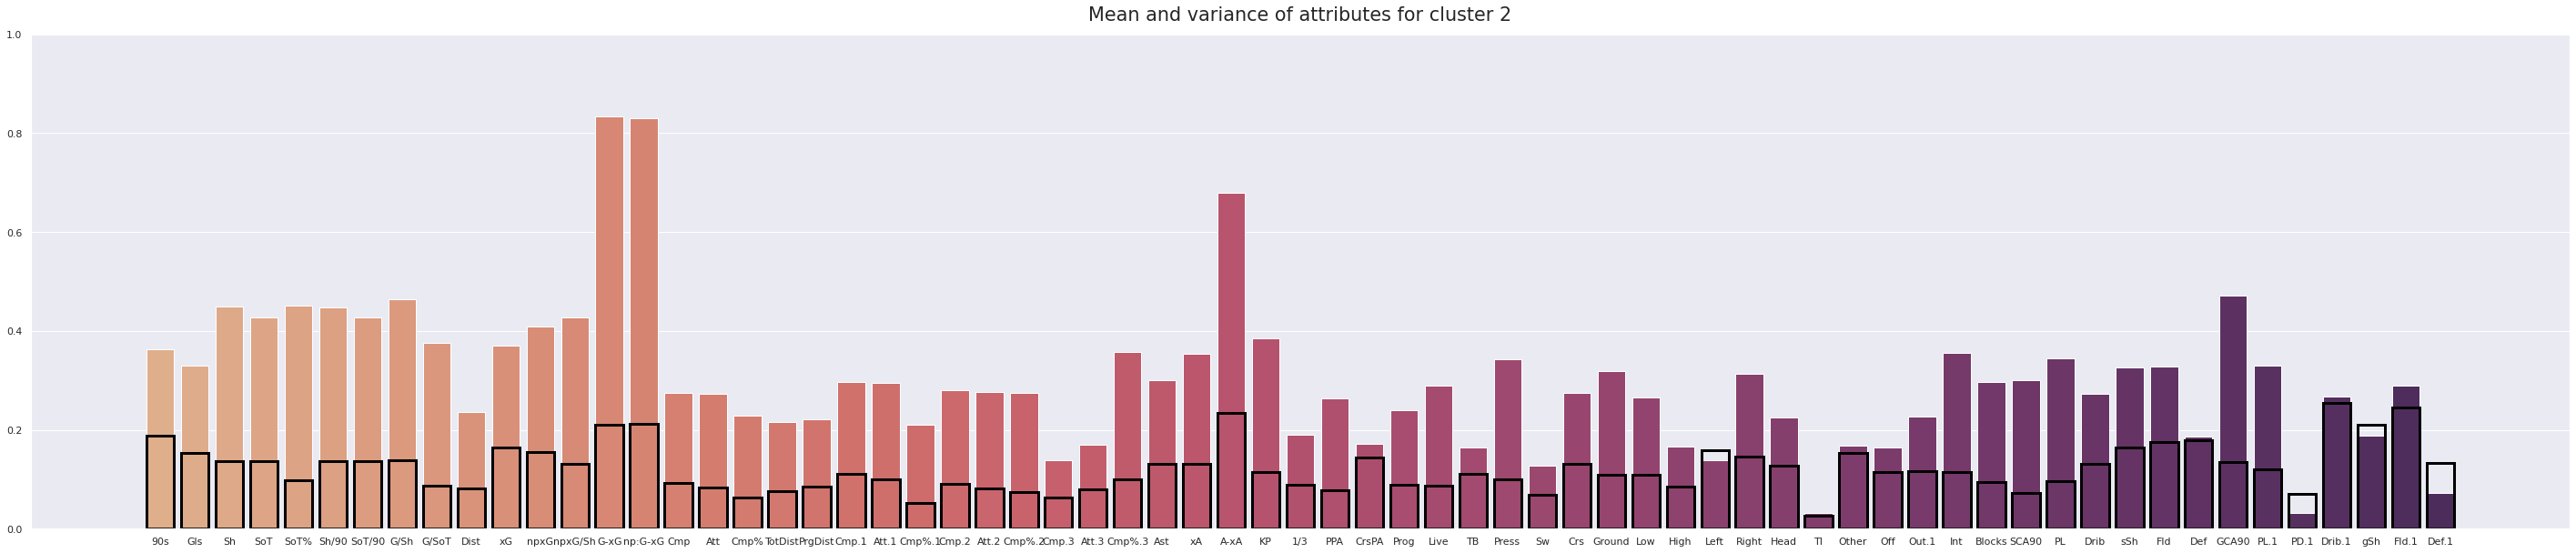

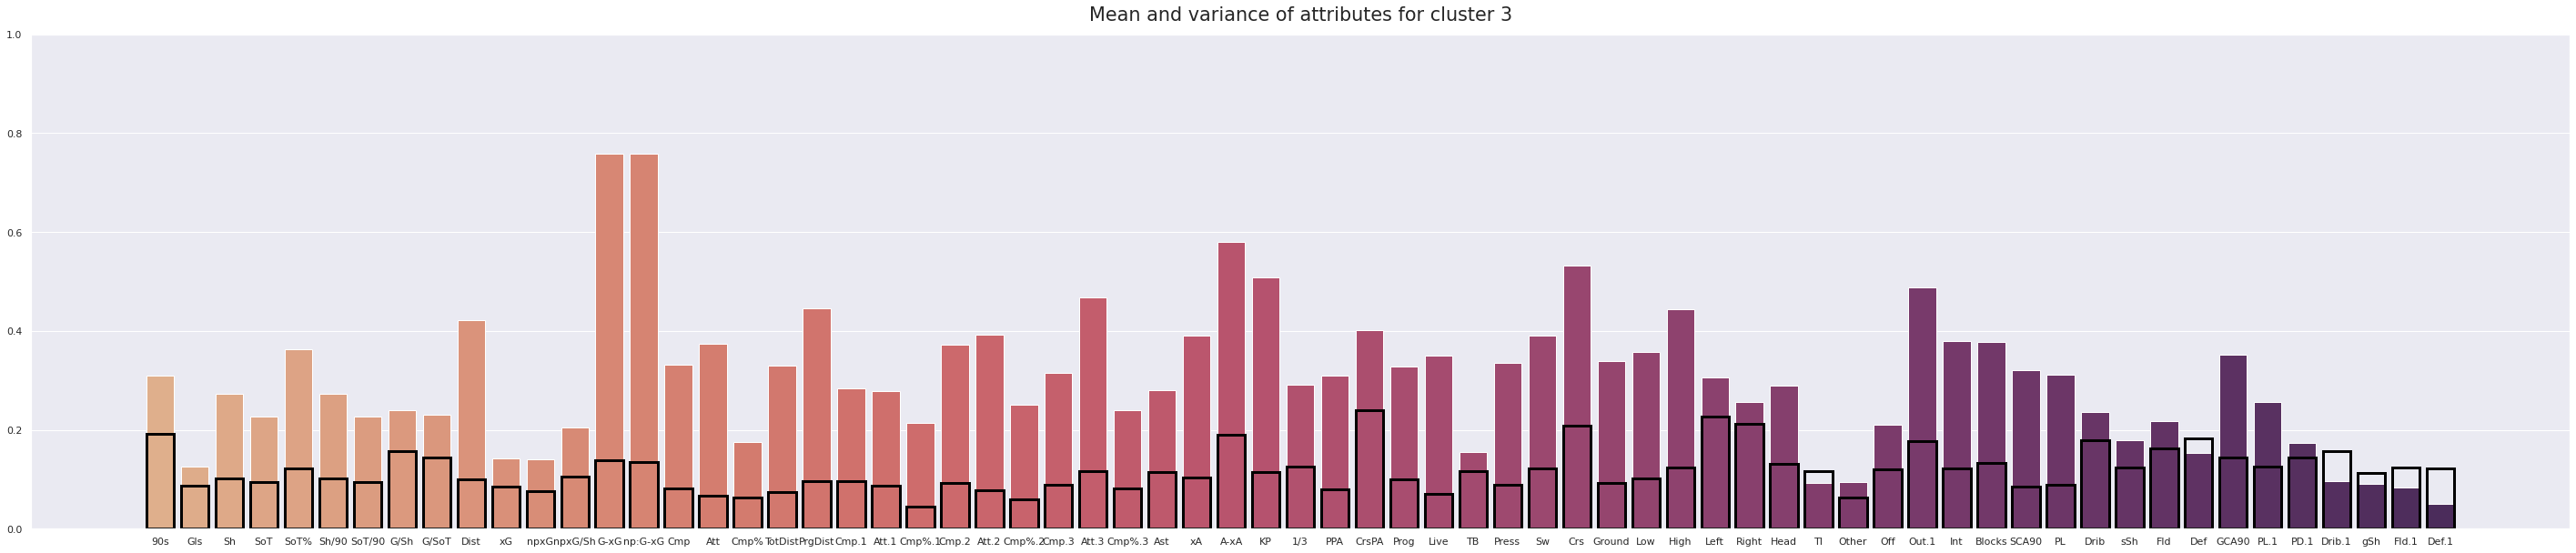

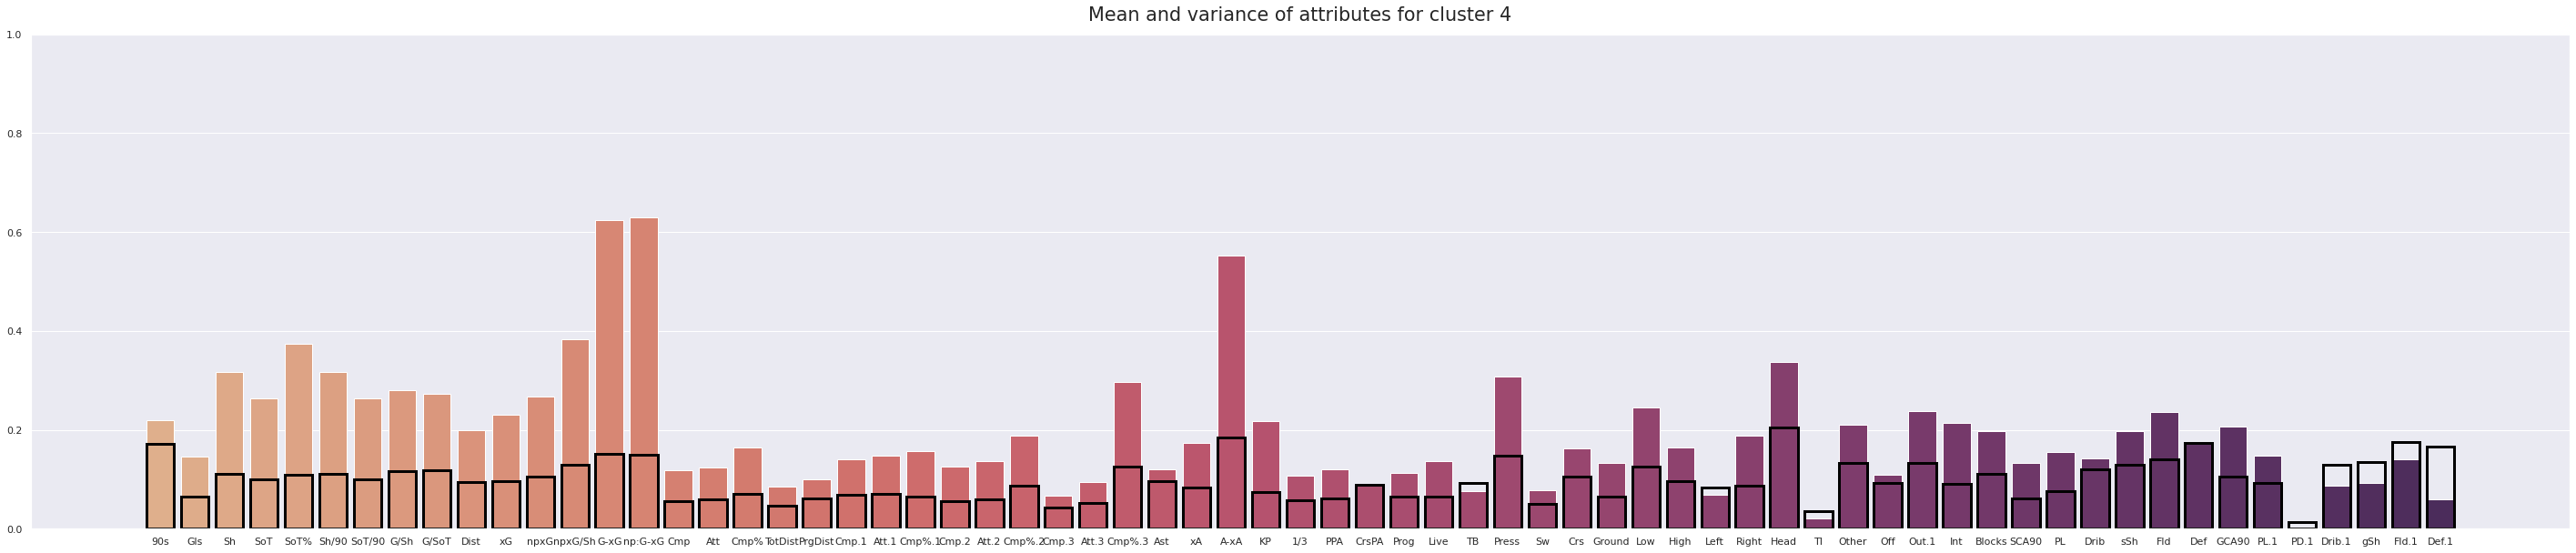

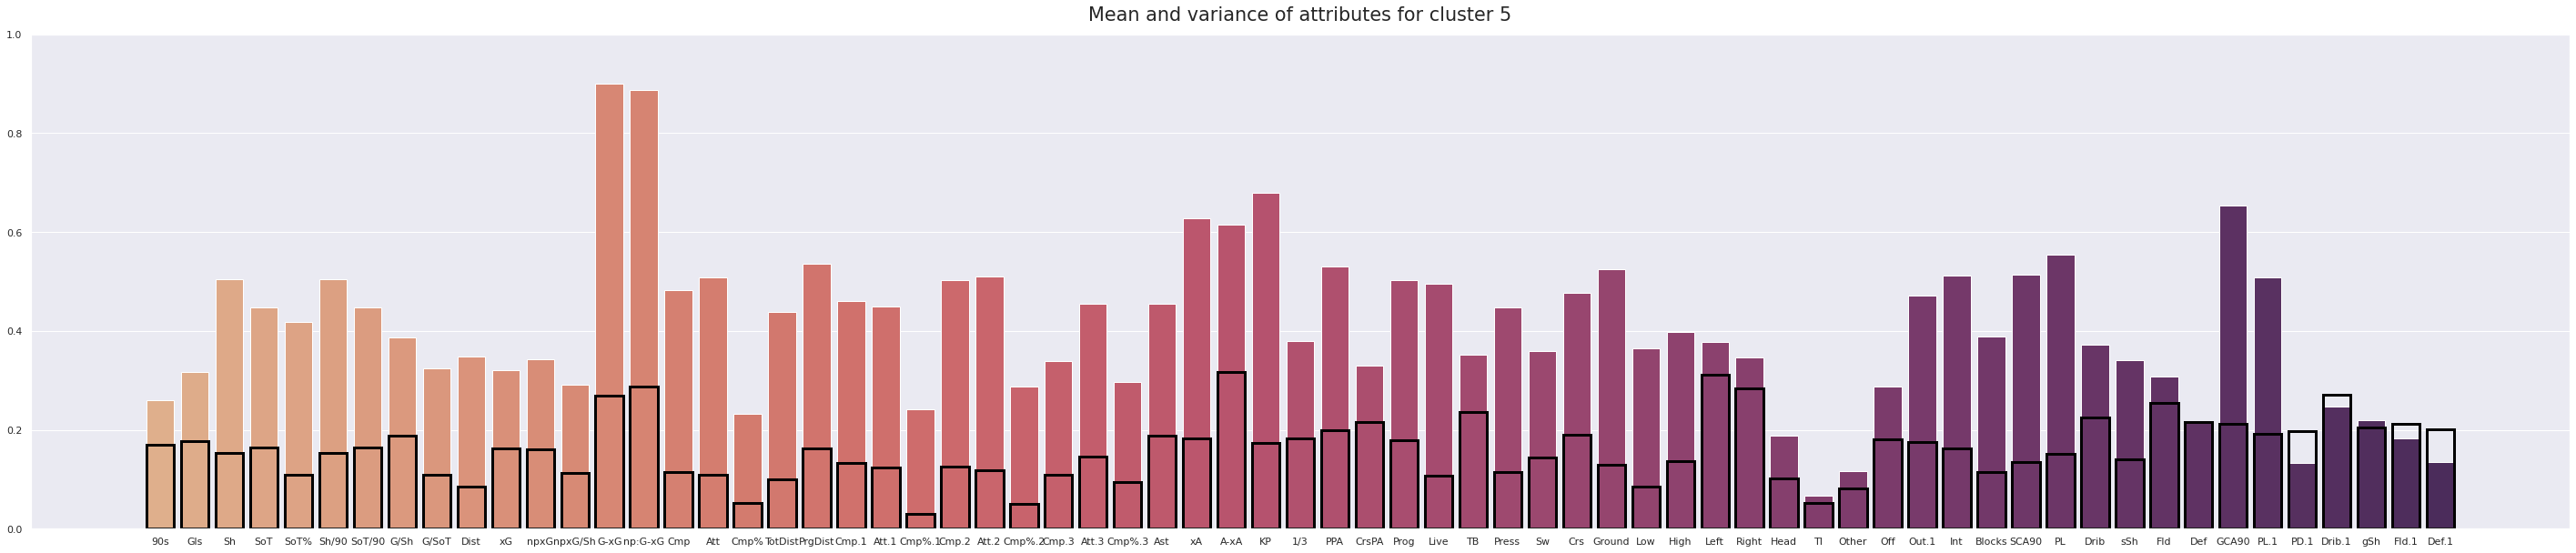

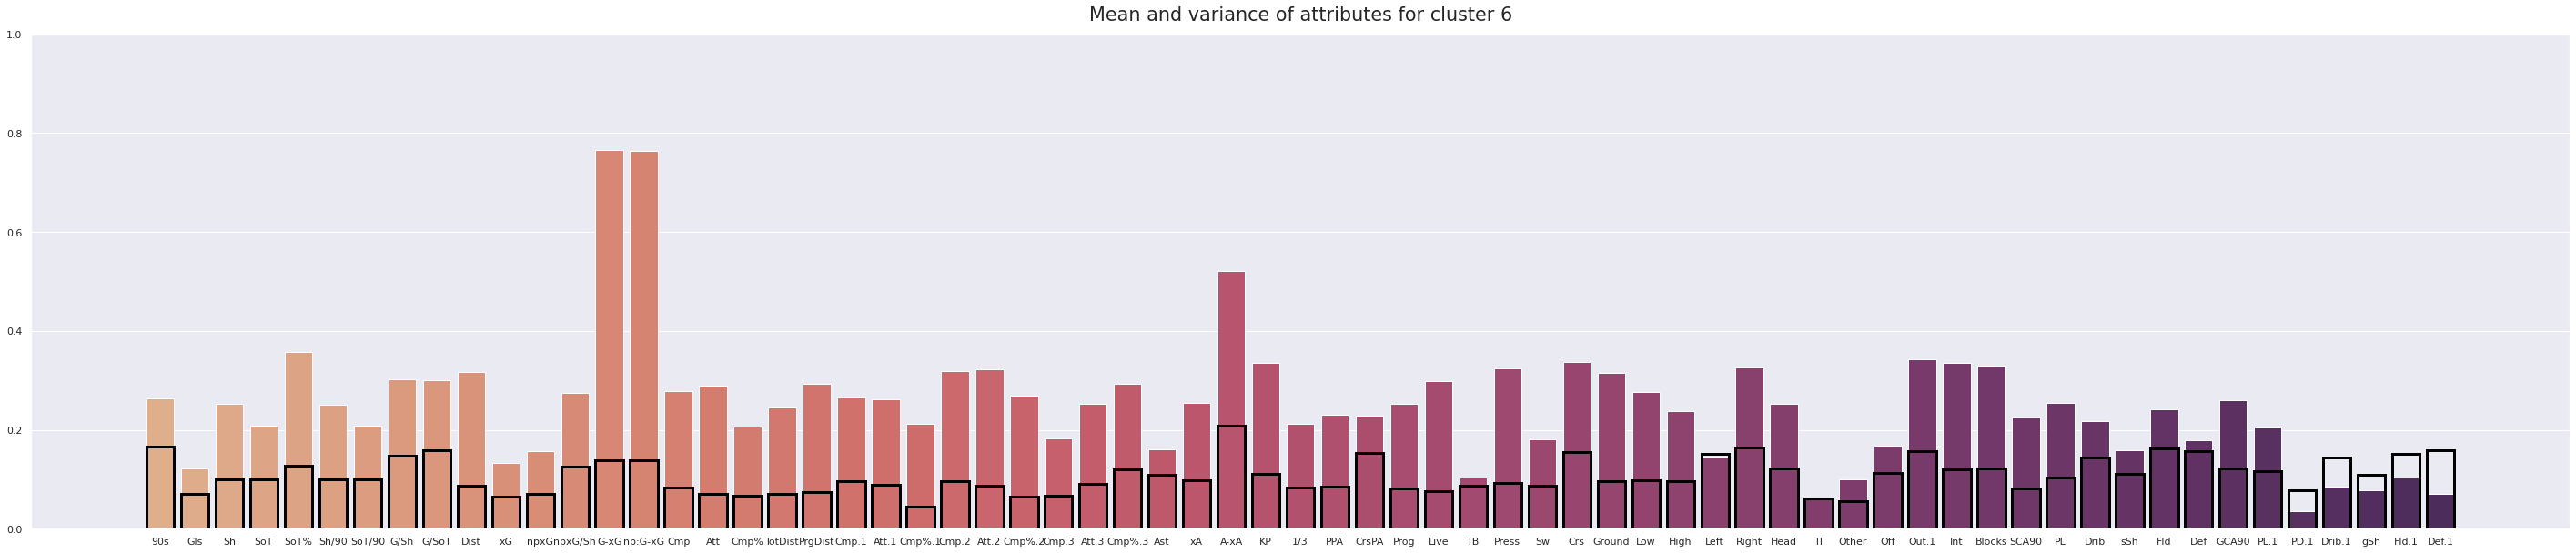

In [19]:
sbn.set_theme()
for i in range(K_opt):
  y_data = clusters["cluster"+str(i)].mean()[2:-1]

  plt.figure(figsize=(50, 10))
  sbn.barplot(x = y_data.keys(), y = y_data, palette = "flare")
  plt.bar(clusters["cluster"+str(i)].keys()[7:-1],clusters["cluster"+str(i)].std()[2:-1], color='None', edgecolor = "black", linewidth = 3)
  plt.title("Mean and variance of attributes for cluster "+str(i), fontsize = "xx-large", pad = 15)
  plt.ylim((0,1))
  plt.savefig("/content/drive/Shareddrives/Kane & Son/ML/Figures/cluster_means_and_variances/"+str(i)+".png")
  plt.show()

Let's now plot the value of each attribute for all clusters using a boxplot with 90% confidence interval.

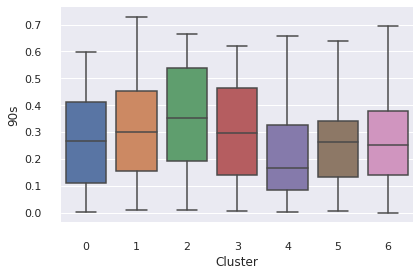

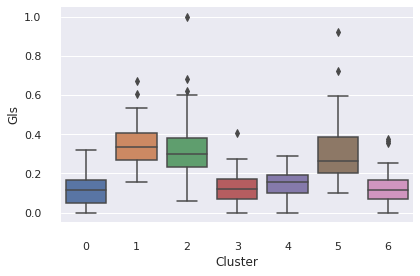

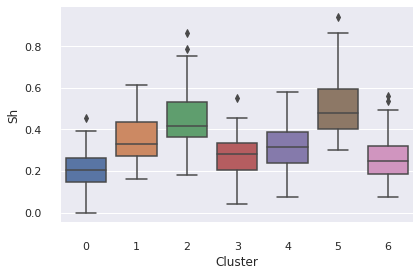

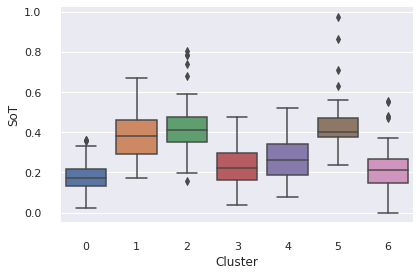

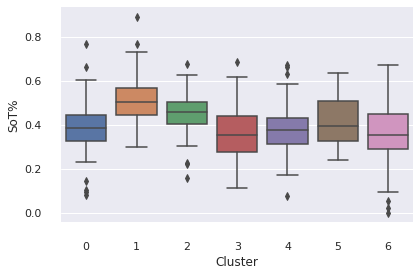

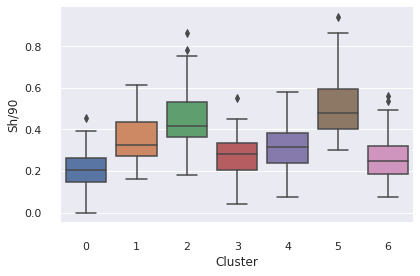

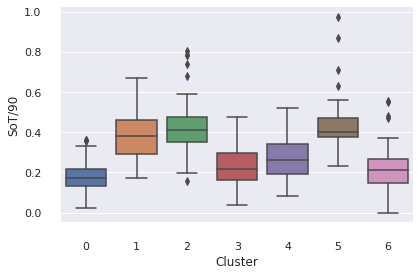

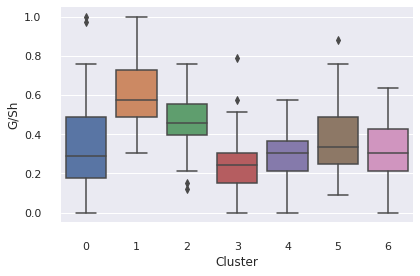

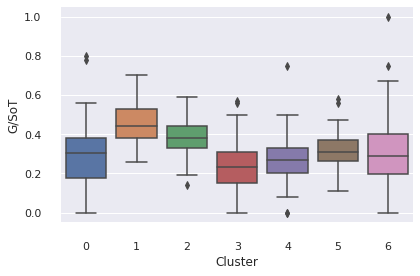

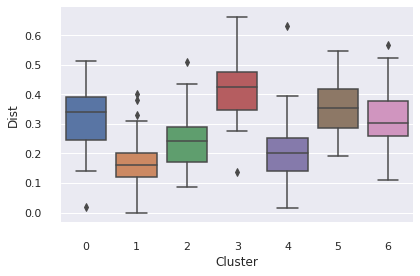

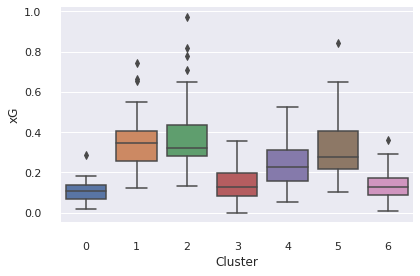

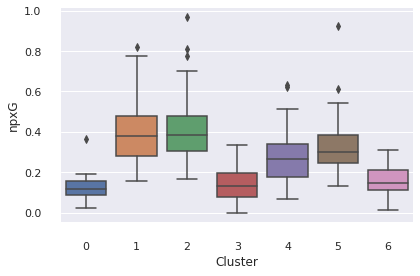

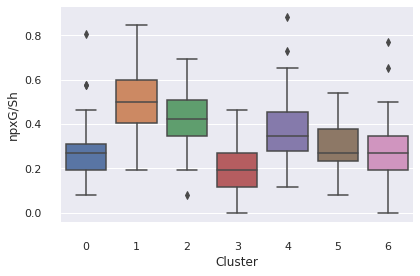

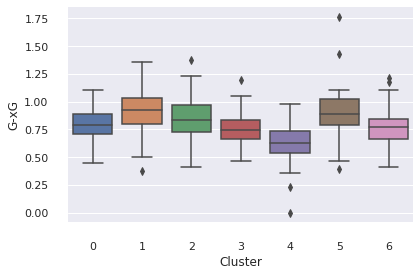

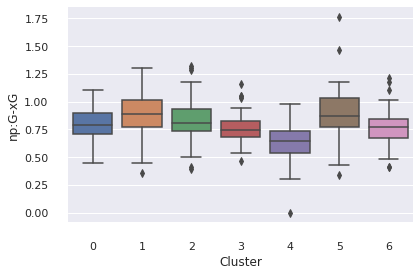

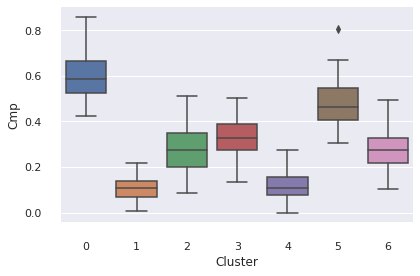

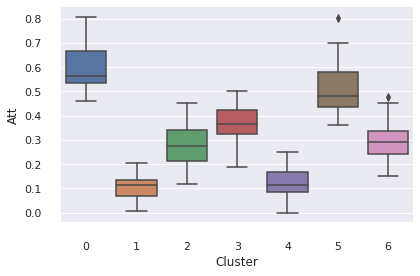

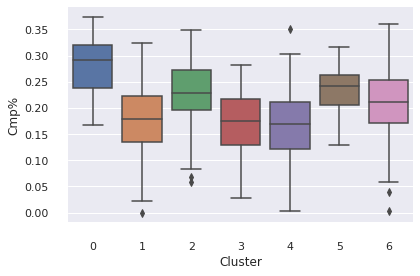

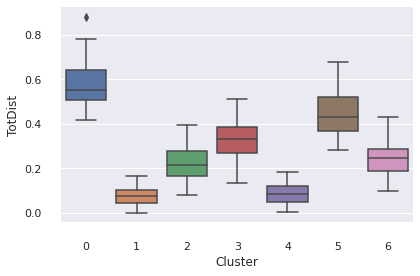

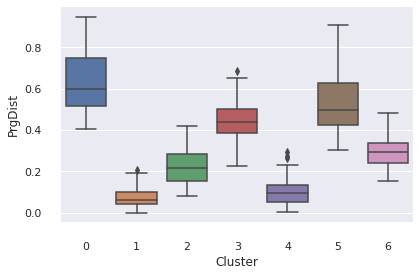

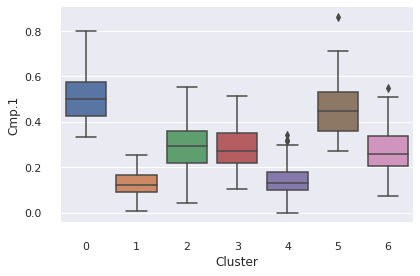

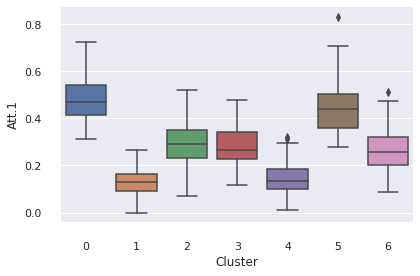

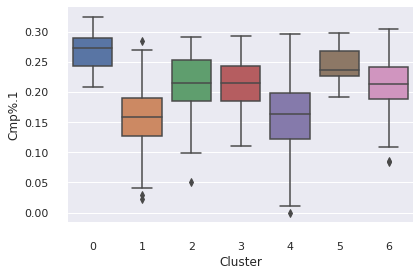

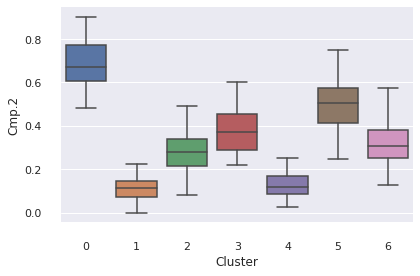

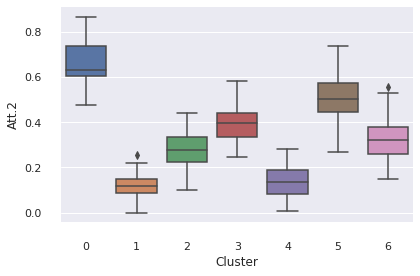

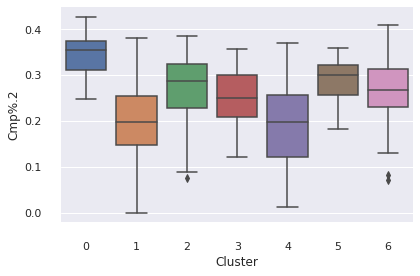

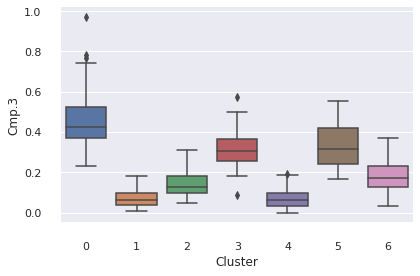

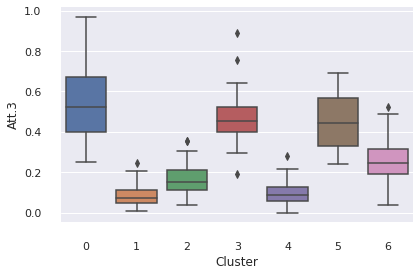

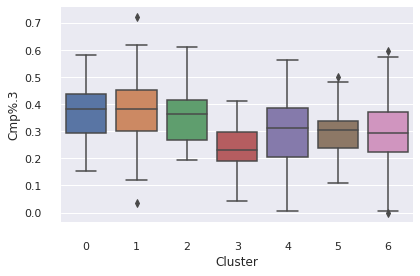

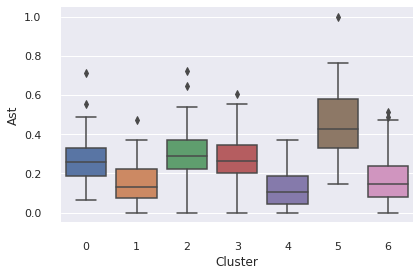

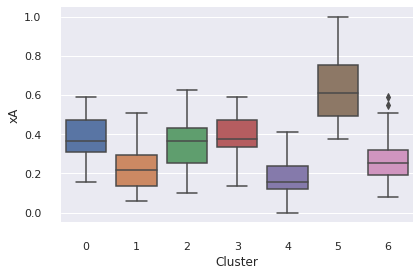

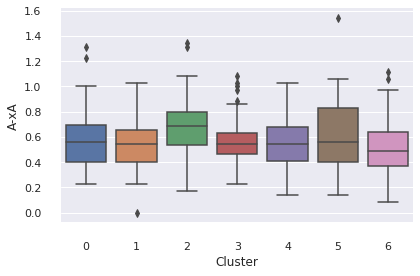

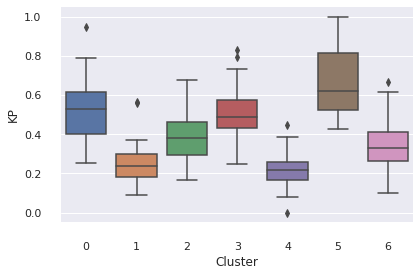

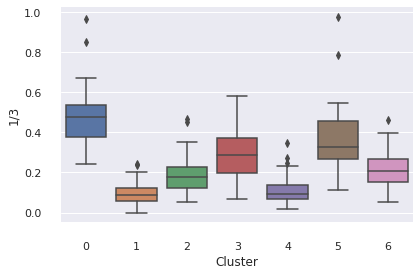

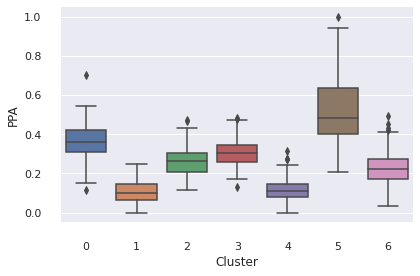

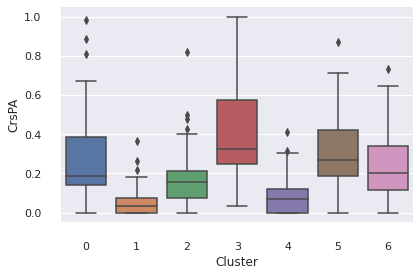

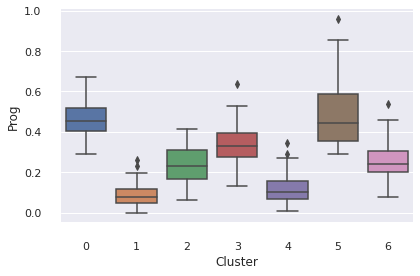

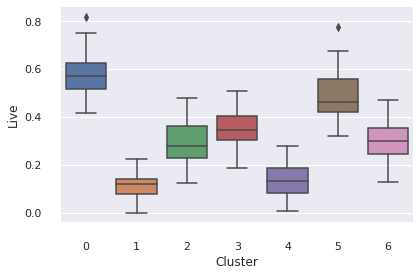

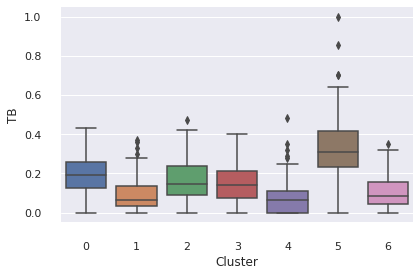

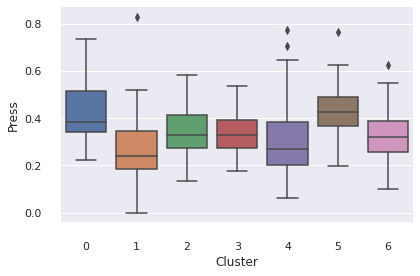

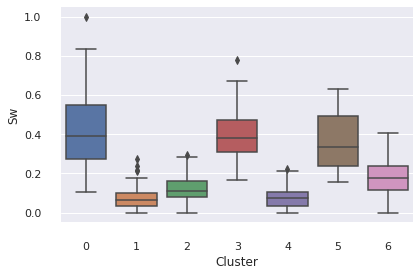

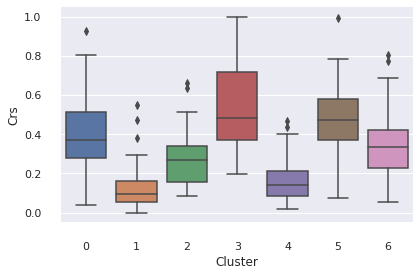

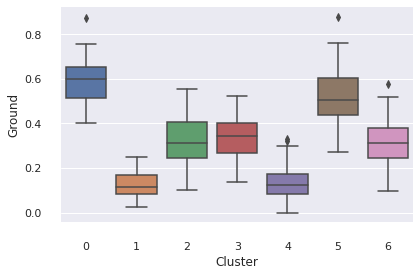

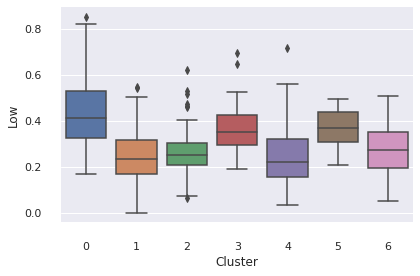

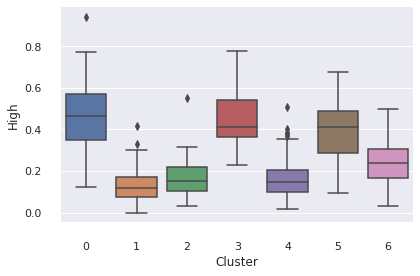

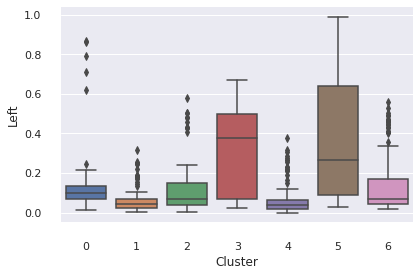

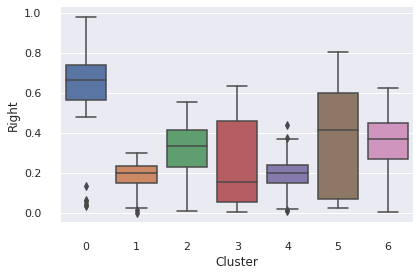

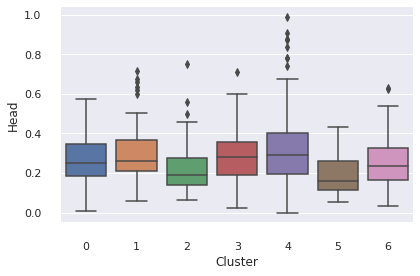

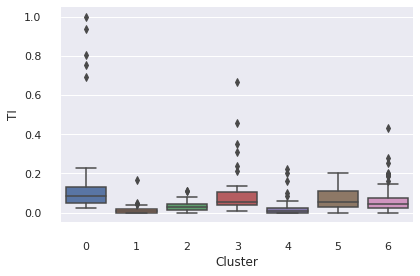

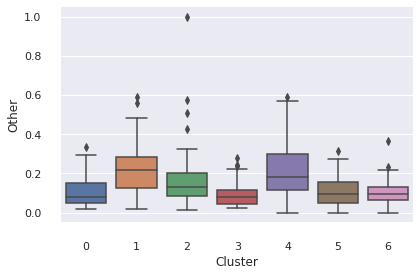

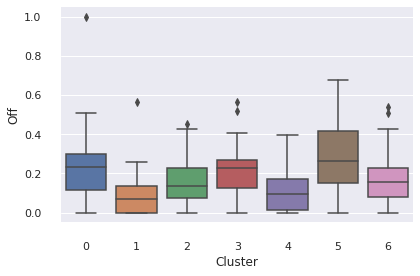

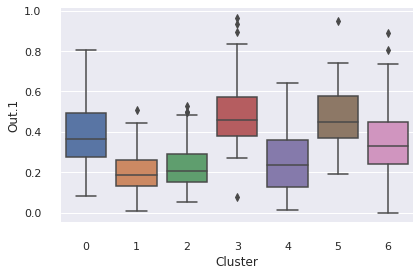

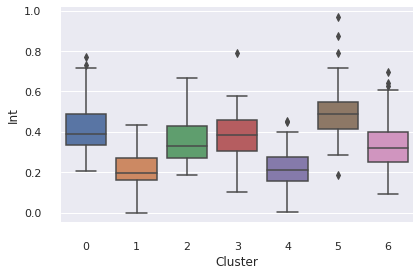

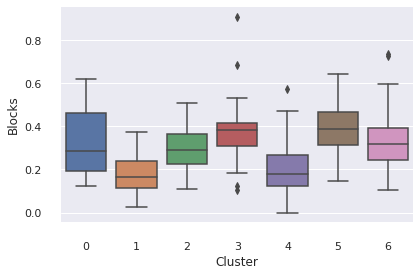

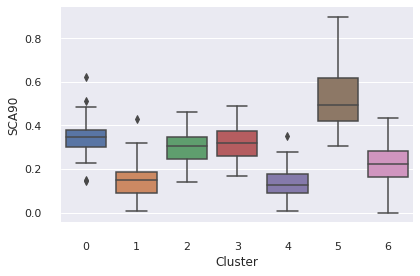

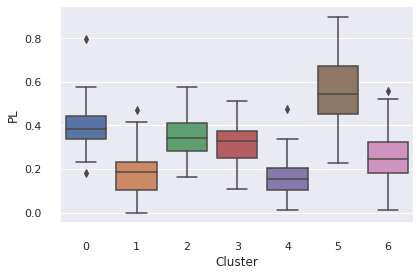

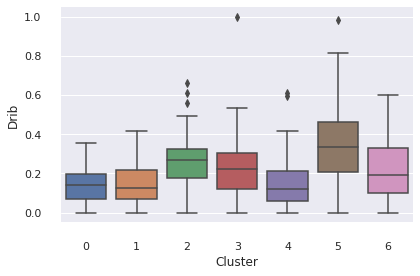

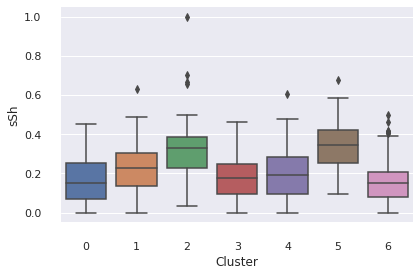

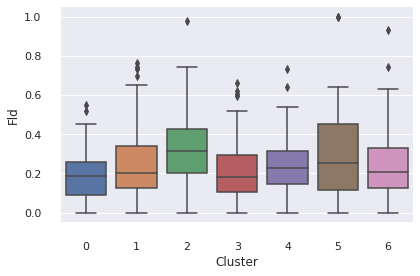

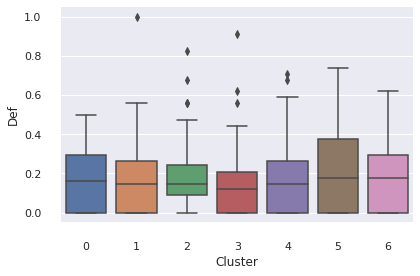

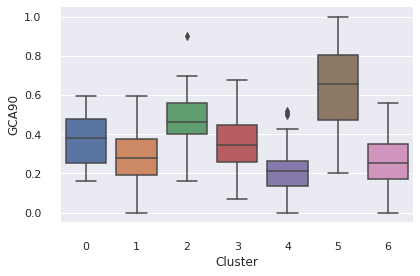

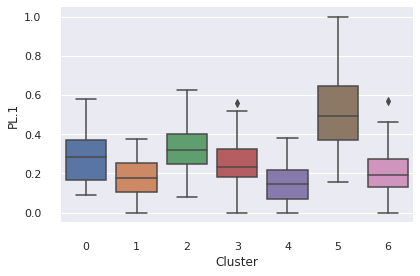

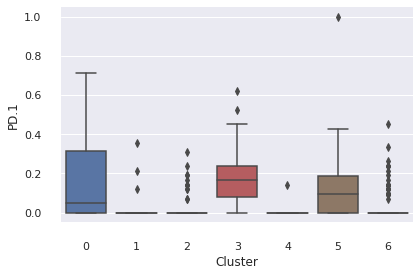

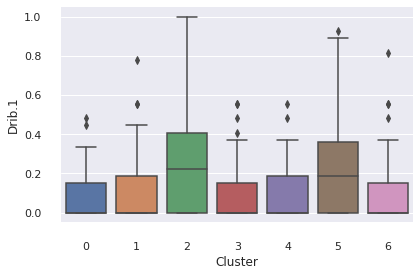

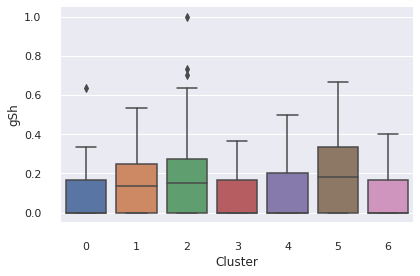

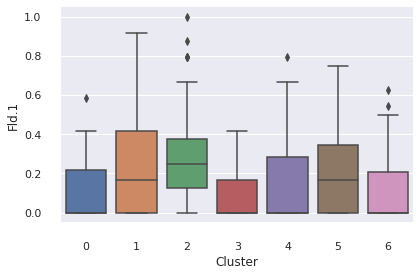

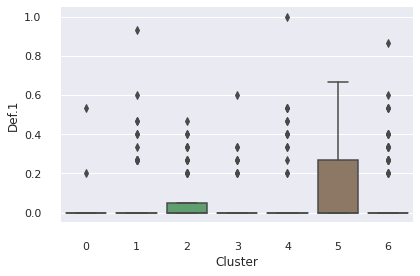

In [20]:

stats.rename(columns = {489: "Cluster", "PassLive": "PL", "PassDead" : "PD", "PassLive.1": "PL.1", "PassDead.1" : "PD.1"}, inplace = True)
for i, att in enumerate(stats.keys()[:-1]):
  sbn.boxplot(x = "Cluster", y = att, data = stats)
  sbn.despine(offset = 10, trim = True)
  plt.tight_layout()
  plt.savefig("/content/drive/Shareddrives/Kane & Son/ML/Figures/boxplots/" + str(i) + ".png")
  plt.show()


## Pizza charts
With these plots we can quickly visualize the mean of 16 important  attributes organized by shooting, passing, pass types and goal and shot creation. 

In [21]:
means = []
for i in range(K_opt-1):
  if i == 0:
    means = pd.concat([clusters["cluster"+str(i)].mean(), clusters["cluster"+str(i+1)].mean()], axis = "columns")
  else:
    means = pd.concat([means, clusters["cluster"+str(i+1)].mean()], axis = "columns")
    
means.columns = ['cluster 0','cluster 1','cluster 2','cluster 3','cluster 4','cluster 5','cluster 6']
means.drop(['Age','Born','Cluster'], axis = 'rows', inplace = True)

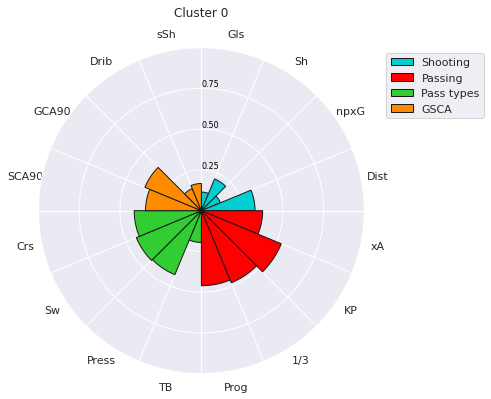

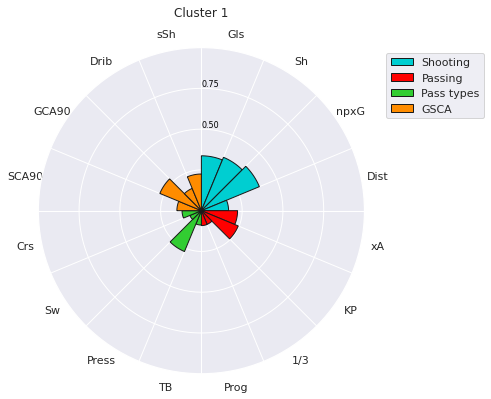

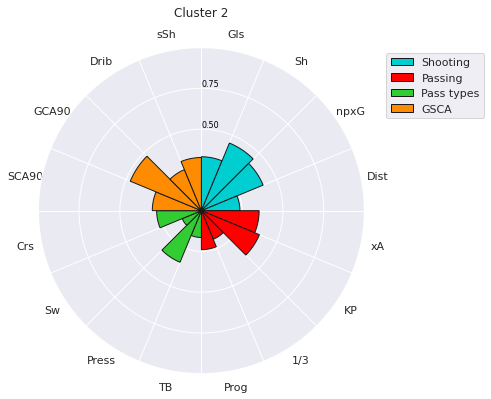

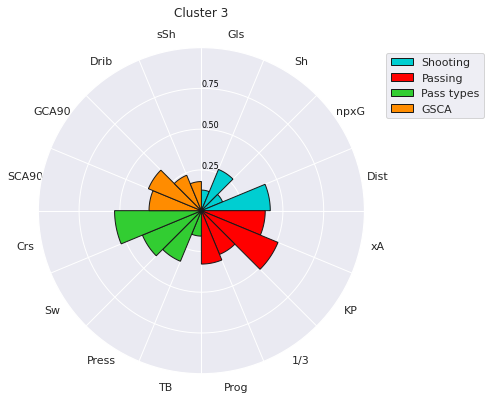

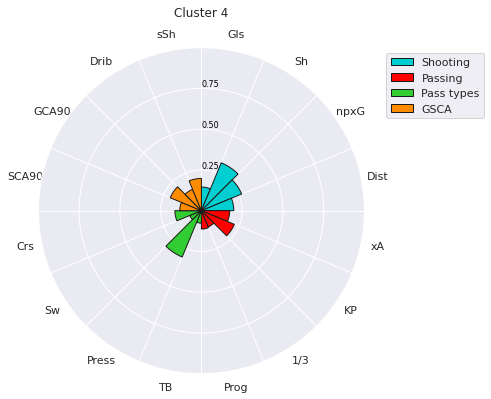

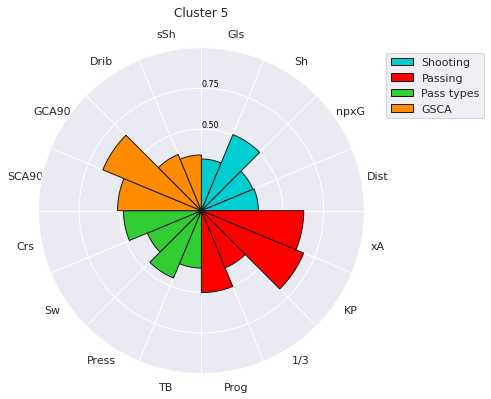

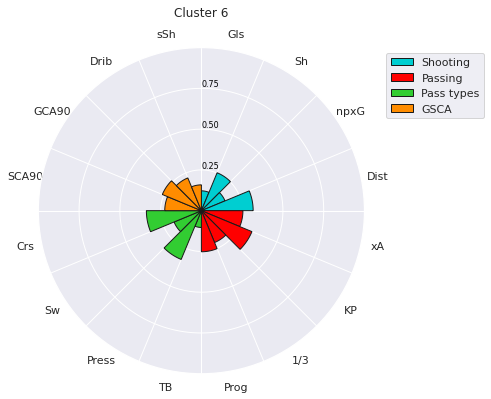

In [22]:
from matplotlib.ticker import FixedLocator
from math import pi

categories = ["Gls", "Sh", "npxG", "Dist", "xA", "KP", "1/3", "Prog", "TB", "Press", "Sw", "Crs", "SCA90", "GCA90", "Drib", "sSh"]
N = len(categories)
angles = np.linspace(0, 2 * pi, N, endpoint=False)
angles_mids = angles + (angles[1] / 2)

for i in range(K_opt):
  fig = plt.figure(figsize=(6, 6))
  ax = plt.subplot(111, polar=True)
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
  ax.set_xticks(angles_mids)
  ax.set_xticklabels(categories)
  ax.xaxis.set_minor_locator(FixedLocator(angles))

  # Draw ylabels
  ax.set_rlabel_position(0)
  ax.set_yticks([0.25, 0.50, 0.75])
  ax.set_yticklabels(['0.25', '0.50', '0.75'], color="black", size=8)
  ax.set_ylim(0, 1)


  ax.bar(angles_mids[:4], means.loc[categories[:4],"cluster "+str(i)], width=angles[1] - angles[0], facecolor='darkturquoise', alpha=1, edgecolor='k', linewidth=1, label = "Shooting")
  ax.bar(angles_mids[4:8], means.loc[categories[4:8],"cluster "+str(i)], width=angles[1] - angles[0], facecolor='red', alpha=1, edgecolor='k', linewidth=1, label = "Passing")
  ax.bar(angles_mids[8:12], means.loc[categories[8:12],"cluster "+str(i)], width=angles[1] - angles[0], facecolor='limegreen', alpha=1, edgecolor='k', linewidth=1, label = "Pass types")
  ax.bar(angles_mids[12:16], means.loc[categories[12:16],"cluster "+str(i)], width=angles[1] - angles[0], facecolor='darkorange', alpha=1, edgecolor='k', linewidth=1, label = "GSCA")


  ax.grid(True, axis='x', which='minor')
  ax.grid(False, axis='x', which='major')
  ax.grid(True, axis='y', which='major')
  ax.set_title('Cluster ' + str(i), pad=15)
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  fig.savefig("/content/drive/Shareddrives/Kane & Son/ML/Figures/Pizza charts/cluster_original"+str(i))
  plt.show()

## Bivariate distributions
Given the high-dimensionality of the clusters if we want to visualize them to see whether they can inform us about key attributes of players we must plot them in dimensionally-reduced spaces. We have chosen to plot sets of two variables against each other. Plotting all variables against each other would be costly and impractical as we would have $\sum_{i=0}^N i$ plots where N is the number of attributes of our data points (in our case 66 attributes or features). As such we have decided which attributes to plot based on prior knowledge of the sport.

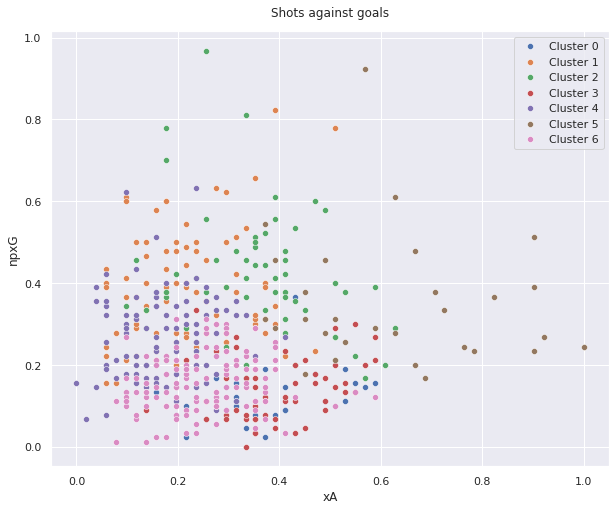

In [23]:
att_x = "xA"
att_y = "npxG"

f, axs = plt.subplots(1, 1, figsize=(10, 8))
for i in range(K_opt):
  sbn.scatterplot(data = clusters["cluster" + str(i)], x = att_x, y = att_y, label = "Cluster "+ str(i))
plt.title("Shots against goals", pad = 15)
plt.legend(loc='upper right')
plt.savefig("/content/drive/Shareddrives/Kane & Son/ML/Figures/biattribute_scatterplots/"+att_x+" vs "+att_y+" all.png")
plt.show()

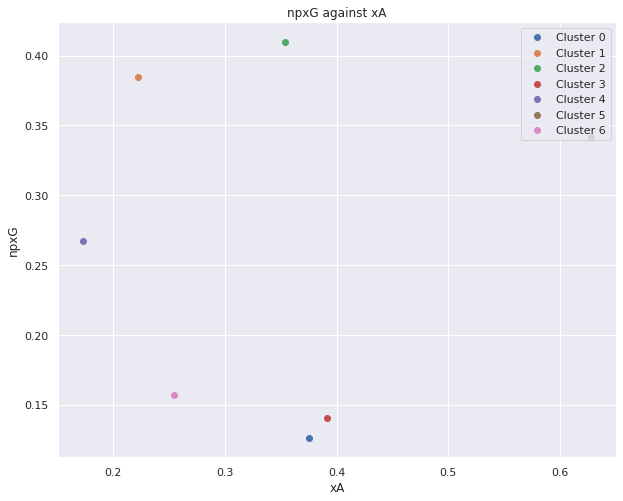

In [24]:
centroids = FW_KMeans.cluster_centers_
index_x = stats.columns.get_loc(att_x)
index_y = stats.columns.get_loc(att_y)

f, axs = plt.subplots(1, 1, figsize=(10, 8))
for i in range(K_opt):
  plt.scatter(x = centroids[i, index_x], y = centroids[i, index_y], label = "Cluster "+ str(i))
plt.title(att_y + " against " + att_x)
plt.xlabel(att_x)
plt.ylabel(att_y)
plt.legend(loc='upper right')
plt.savefig("/content/drive/Shareddrives/Kane & Son/ML/Figures/biattribute_scatterplots/"+att_x+" vs "+att_y+" centroids.png")
plt.show()

In [25]:
centroids[0, index_x]

0.3756127450980392


## Feature Selection

Now, we would like to analyze and interpret the clustering results obtained. However, there is a major problem here: the large number of features used. Since we are working with an unsupervised algorithm, there's not a clear technique nor pipeline to follow in this case and this topic is considered to be very trendy in the ML research. 

So, to tackle this issue, we will first try an exhaustive approach in order to generate a subset of 15 parameters. What we are going to do is start with a subset of only one feature selected by hand (in this case we have selected Sh/90 (Shots per 90) since we thought it was an interesting feature to use) and we will exhaustively perform the clustering by adding only one feature to our subset, which will be changed in order to test with all the parameters. Then, each of the clustering results will be measured using the Davies Boulding Score, a clustering performance metric that computes the average similarity of each cluster with its most similiar cluster. This will allow us to select the feature that gives a clustering with an inter-cluster larger distance and less dispersed, which we interpret it as a better performing cluster. The feature will be added to our subset of parameters. The algorithm will be executed until we have selected the number of features that we want. 

The results will be plotted in a similar fashion as we have done before.


In [ ]:
from sklearn.metrics import davies_bouldin_score  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html

eval = []
features = []
for cols in stats.columns:
  features.append(cols)
first = features[0]  
features[0] = features[5]  # we define which will be the first feature to include
features[5] = first
features_sel = [features[0]]
n_sel = 14 # we set here the number of features to be selected
for i in range (n_sel):
  for i in range (len(features)-1):
    FW_KMeans = KMeans(n_clusters = K_opt).fit(stats[features_sel+[features[i+1]]])
    eval.append(davies_bouldin_score(stats, FW_KMeans.labels_))

  features_sel.append(features[eval.index(np.min(eval))])
  features.pop(eval.index(np.min(eval)))
  eval = []

print(features_sel)

In [ ]:
stats2 = stats[features_sel].copy()

FW_KMeans = KMeans(n_clusters = K_opt).fit(stats2) # we re-classify the data using the new subset of features

stats2.loc[:, len(stats2)] = FW_KMeans.labels_
Data_visual2 = pd.concat([forwards, stats2], axis = "columns")
Data_visual2.rename(columns = {489: "Cluster_new", "PassLive": "PL", "PassDead" : "PD", "PassLive.1": "PL.1", "PassDead.1" : "PD.1"}, inplace = True)

In [ ]:
clusters_new = {}
for i in range(K_opt):
  aux = Data_visual2.loc[Data_visual2["Cluster_new"] == i, :].copy()
  aux.to_csv("cluster_new"+str(i))
  clusters_new["cluster"+str(i)] = aux

In [ ]:
for i in range(K_opt):
  plt.figure(figsize=(50, 10))
  sbn.barplot(x = clusters_new["cluster"+str(i)].keys()[7:-1], y = clusters_new["cluster"+str(i)].mean()[2:-1], palette = "flare")
  plt.bar(clusters_new["cluster"+str(i)].keys()[7:-1],clusters_new["cluster"+str(i)].std()[2:-1], color='None', edgecolor = "black", linewidth = 3)
  plt.title("Mean of attributes for cluster "+str(i), fontsize = "xx-large")
  plt.ylim((0,1))
  plt.savefig("/content/drive/Shareddrives/Kane & Son/ML/Figures/cluster_means_and_variances/exhaustive"+str(i)+".png")
  plt.show()

In [ ]:
for i, att in enumerate(stats2.keys()[:-1]):
  sbn.boxplot(x = "Cluster", y = att, data = stats)
  sbn.despine(offset=10, trim=True)
  plt.savefig("/content/drive/Shareddrives/Kane & Son/ML/Figures/boxplots/exhaustive" + str(i) + ".png")
  plt.show()


After analyzing the clusters formed using the last system, we weren't completely satisfied with the classification done since there were some variables that had a huge influence on the clustering formation and, for our opinion, they were very biased towards them. So, we will now study which are the critical features for clustering. To do so, we will assume that those features that vary the most among clusters are the ones that have the most influence in the clustering formation. As such, we will study and plot the variance of the mean of each attribute among clusters.


In [ ]:
means = []
for i in range(K_opt-1):
  if i == 0:
    means = pd.concat([clusters["cluster"+str(i)].mean(), clusters["cluster"+str(i+1)].mean()], axis = "columns")
  else:
    means = pd.concat([means, clusters["cluster"+str(i+1)].mean()], axis = "columns")

sigma = means.std(axis = 1)
sigma.drop(labels = ["Age", "Born", "Cluster"], inplace = True)
sigma = sigma.sort_values()

plt.figure(figsize=(50, 10))
sbn.barplot(x = sigma.keys(), y = sigma, palette = "flare")
plt.title("Standard deviation of the mean of each attribute among the clusters", fontsize = "xx-large", pad = 15)
plt.savefig("/content/drive/Shareddrives/Kane & Son/ML/Figures/std of cluster means.png")
plt.show()

We can observe in this plot that the fifteen most relevant features, understanding relevance as the ones that vary the most between clusters, are:

- PrgDist
- Cmp.2     
- Att.2
- Att.3
- Att
- TotDist
- Ground
- Cmp
- Kp
- Live
- GCA90
- Prog
- Crs
- xA
- PPA

We'll now classify using only these features.

In [ ]:
selected_features = ['PrgDist','Cmp.2','Att.2','Att.3','Att','TotDist','Ground','Cmp',
                     'KP', 'Live', 'GCA90', 'Prog', 'Crs', 'xA', 'PPA']

stats2 = stats[selected_features].copy()

FW_KMeans = KMeans(n_clusters = K_opt).fit(stats2) # we re-classify the data using the new subset of features

stats2.loc[:, len(stats2)] = FW_KMeans.labels_
Data_visual2 = pd.concat([forwards, stats2], axis = "columns")
Data_visual2.rename(columns = {489: "Cluster_new", "PassLive": "PL", "PassDead" : "PD", "PassLive.1": "PL.1", "PassDead.1" : "PD.1"}, inplace = True)

In [ ]:
clusters_new = {}
for i in range(K_opt):
  aux = Data_visual2.loc[Data_visual2["Cluster_new"] == i, :].copy()
  aux.to_csv("/content/drive/Shareddrives/Kane & Son/ML/Data/Clusters/feature selected/cluster_new"+str(i))
  clusters_new["cluster"+str(i)] = aux

In [ ]:
for i in range(K_opt):
  plt.figure(figsize=(50, 10))
  sbn.barplot(x = clusters_new["cluster"+str(i)].keys()[7:-1], y = clusters_new["cluster"+str(i)].mean()[2:-1], palette = "flare")
  plt.bar(clusters_new["cluster"+str(i)].keys()[7:-1],clusters_new["cluster"+str(i)].std()[2:-1], color='None', edgecolor = "black", linewidth = 3)
  plt.title("Mean of attributes for cluster "+str(i), fontsize = "xx-large")
  plt.ylim((0,1))
  plt.show()

After giving a first glance to our results, we are satisfied with the clusters formed and we will try now to better interpret those results. Therefore, we will compare the different clusters using the mean value of each of the parameters for each of the clusters. We will plot these values in a very visual appealing way using "Pizza charts", which will also allow us to interpret the differences between clusters and which are the parameters that better characterize each of the clusters.

In [ ]:
means_fs = []
for i in range(K_opt-1):
  if i == 0:
    means_fs = pd.concat([clusters_new["cluster"+str(i)].mean(), clusters_new["cluster"+str(i+1)].mean()], axis = "columns")
  else:
    means_fs = pd.concat([means_fs, clusters_new["cluster"+str(i+1)].mean()], axis = "columns")
    
means_fs.columns = ['cluster 0','cluster 1','cluster 2','cluster 3','cluster 4','cluster 5','cluster 6']
means_fs.drop(['Age','Born','Cluster_new'], axis = 'rows', inplace = True)

In [ ]:
from matplotlib.ticker import FixedLocator
from math import pi

categories = list(means_fs.index)
N = len(categories)
angles = np.linspace(0, 2 * pi, N, endpoint=False)
angles_mids = angles + (angles[1] / 2)

for i in range (K_opt):
  fig = plt.figure(figsize=(6, 6))
  ax = plt.subplot(111, polar=True)
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
  ax.set_xticks(angles_mids)
  ax.set_xticklabels(categories)
  ax.xaxis.set_minor_locator(FixedLocator(angles))

  # Draw ylabels
  ax.set_rlabel_position(0)
  ax.set_yticks([0.25, 0.50, 0.75])
  ax.set_yticklabels(['0.25', '0.50', '0.75'], color="black", size=8)
  ax.set_ylim(0, 1)


  ax.bar(angles_mids, means_fs.iloc[:,i], width=angles[1] - angles[0],
        facecolor='darkturquoise', alpha=1, edgecolor='darkcyan', linewidth=2)

  ax.grid(True, axis='x', which='minor')
  ax.grid(False, axis='x', which='major')
  ax.grid(True, axis='y', which='major')
  ax.set_title('Cluster ' + str(i), pad=15)
  fig.savefig("/content/drive/Shareddrives/Kane & Son/ML/Figures/Pizza charts/cluster"+str(i))
  plt.show()

In [ ]:
for i, att in enumerate(stats2.keys()[:-1]):
  sbn.boxplot(x = "Cluster", y = att, data = stats2)
  sbn.despine(offset=10, trim=True)
  plt.savefig("/content/drive/Shareddrives/Kane & Son/ML/Figures/boxplots/final" + str(i) + ".png")
  plt.show()